In [9]:
# !pipreqsnb --force
!pip3 install -q -r requirements.txt

In [10]:
import pandas as pd
import seaborn as sns
import re

In [11]:
import xgboost as xgb

from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV


RSEED = 42
N_JOBS = -1 #4
N_FOLDS = 3

I chose gradient boosting as my baseline since it's SOTA amongst classic ML algorithms. As i have 3-4 hours for this task only and don't have any GPU here, i stick to this baseline and its proper implementation. In general, CatBoost might be faster than XGBoost, but I don't have any plans for categorical features or context-based password text processing thus stick to XGBoost

In [71]:
df_ = pd.read_csv('passwords.csv')
df_.head()

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2


In [60]:
# check fo NaNs and duplicated rows
df_.isna().any(), df_['password'].duplicated().any()

(password    False
 strength    False
 dtype: bool,
 False)

In [61]:
# shallow copy of original dataframe, measure sequence length (1st feature)
df = df_.copy()
length = df_['password'].str.len()
length.describe()

count    100000.000000
mean          9.975540
std           2.766384
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          45.000000
Name: password, dtype: float64

In [62]:
# check if there are imbalanced classes
def check_balance(dfr):
  N = dfr.shape[0]
  try:
    # last column treated as target for dataframe input
    tar = dfr[dfr.columns[-1]]
  except AttributeError:
    # single array input case
    tar = dfr
  finally:
    return (100*tar.value_counts()/N).to_frame('counts')

check_balance(df_)
# sheesh ... our strategy is to oversample last 2 classes (later)

,counts
1,74.278
0,13.428
2,12.294


In [63]:
# count pattern ocurrences,
df['fd'] = df['password'].str.count('\d') # all digits
df['fu'] = df['password'].str.count('[A-Z]') # all uppercase letters
df['fl'] = df['password'].str.count('[a-z]') # all lowercase letters
df['fx'] = df['password'].str.count('[\W_]') # all non-word w/ underscores
# There are umlauts, accents and some math symbols (plusminus, equality...) left

In [64]:
# separate target
target = df['strength']
# gonna use ocurrences as features thus get rid of password string column
features_ = df.drop(['password', 'strength'], axis=1)
# I prefer 'the rest symbols quantity' instead of 'overall length' feature
# using both leads to multicollinearity (=> overfitting)
features_['fr'] = length - features_.sum(axis=1, numeric_only=True)

I decided to match 4 independent regular expression patterns within each password string cause these are obviously distinctive numeric features, moreover their proportions aka frequencies are independent of password length, this allows to handle various input sequences

Therefore, I have 4+1 non-collinear features

In [65]:
# divide by each element's overall length to get features within [0..1] range
features = features_.apply(lambda f: f/length, axis=0)
features.describe()

,fd,fu,fl,fx,fr
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.328459,0.053249,0.614548,0.003699,0.000044
std,0.198993,0.153707,0.221159,0.027665,0.002613
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.187500,0.000000,0.500000,0.000000,0.000000
50%,0.300000,0.000000,0.666667,0.000000,0.000000
75%,0.400000,0.000000,0.777778,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.333333


In [66]:
# handle imbalanced classes
ros = RandomOverSampler(random_state=RSEED)
X, y = ros.fit_resample(X=features, y=target)
check_balance(y)

,counts
1,33.333333
2,33.333333
0,33.333333


In [67]:
# first of all, put aside test dataset
# btw, we ensure that train/test parts have same distribution of labels
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y.values,
                                                    random_state=RSEED,
                                                    )

In [68]:
cl = xgb.XGBClassifier(objective='multi:softmax',
                       num_class = 3,
                       n_jobs=N_JOBS,
                       seed=RSEED,
                       early_stopping_rounds=50,
                       )

# parameters to be passed to fit method (directly)
cv_fp = {"eval_set": [(X_test, y_test)], "verbose": 50}
# NB test dataset is only used for early stopping, not for learning!

In [69]:
# parameter grid for gridsearch (some options turned off to make it faster)
opt_parameters = {
    "learning_rate": [0.08, 0.1, 0.12],
    "max_depth": [5, 6],
    "n_estimators": [1000],
    # "min_child_weight": [2, 5],
    # "gamma": [0, 0.01],
    # "subsample": [0.9, 1.0],
    # "early_stopping_rounds": [50, 100],
}

random_search = RandomizedSearchCV(
    estimator=cl,
    param_distributions=opt_parameters,
    n_iter=4, # just 4 random options are chosen to save time
    scoring="f1_macro", # as we don't care about imbalanced classes anymore
    n_jobs=N_JOBS,
    verbose=3,
    cv=N_FOLDS - 1, # utilizes stratified k-fold w/o shuffling by default
    random_state=RSEED,
)

In [70]:
random_search.fit(X_train, y_train, **cv_fp)
optimal_cfg = random_search.best_params_
optimal_cfg

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[0]	validation_0-mlogloss:1.00560
[50]	validation_0-mlogloss:0.16207
[100]	validation_0-mlogloss:0.12876
[150]	validation_0-mlogloss:0.12470
[200]	validation_0-mlogloss:0.12346
[250]	validation_0-mlogloss:0.12293
[300]	validation_0-mlogloss:0.12243
[350]	validation_0-mlogloss:0.12220
[400]	validation_0-mlogloss:0.12213
[450]	validation_0-mlogloss:0.12210
[500]	validation_0-mlogloss:0.12208
[550]	validation_0-mlogloss:0.12207
[600]	validation_0-mlogloss:0.12206
[650]	validation_0-mlogloss:0.12204
[700]	validation_0-mlogloss:0.12203
[750]	validation_0-mlogloss:0.12201
[800]	validation_0-mlogloss:0.12201
[850]	validation_0-mlogloss:0.12199
[900]	validation_0-mlogloss:0.12198
[940]	validation_0-mlogloss:0.12198


{'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.08}

In [72]:
optimal_cfg = {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.08}

# reinit w/ best parameters (according to Randomized GSCV)
cl = xgb.XGBClassifier(objective='multi:softmax',
                       num_class = 3,
                       n_jobs=N_JOBS,
                       seed=RSEED,
                       early_stopping_rounds=50,
                       **optimal_cfg,
                       )

In [73]:
# N_FOLD cross-validation over train dataset
kf_cv_scores = cross_val_score(cl,
                               X_train,
                               y_train,
                               scoring="f1_macro",
                               cv=N_FOLDS,
                               fit_params=cv_fp,
                               )

f"{N_FOLDS}-fold CV F1 score: {kf_cv_scores.mean():.2f}"

[0]	validation_0-mlogloss:1.00561
[50]	validation_0-mlogloss:0.16232
[100]	validation_0-mlogloss:0.12863
[150]	validation_0-mlogloss:0.12447
[200]	validation_0-mlogloss:0.12327
[250]	validation_0-mlogloss:0.12259
[300]	validation_0-mlogloss:0.12239
[350]	validation_0-mlogloss:0.12238
[400]	validation_0-mlogloss:0.12237
[450]	validation_0-mlogloss:0.12235
[500]	validation_0-mlogloss:0.12232
[550]	validation_0-mlogloss:0.12230
[600]	validation_0-mlogloss:0.12227
[650]	validation_0-mlogloss:0.12227
[700]	validation_0-mlogloss:0.12224
[750]	validation_0-mlogloss:0.12221
[800]	validation_0-mlogloss:0.12221
[809]	validation_0-mlogloss:0.12221
[0]	validation_0-mlogloss:1.00561
[50]	validation_0-mlogloss:0.16267
[100]	validation_0-mlogloss:0.12921
[150]	validation_0-mlogloss:0.12452
[200]	validation_0-mlogloss:0.12338
[250]	validation_0-mlogloss:0.12291
[300]	validation_0-mlogloss:0.12259
[350]	validation_0-mlogloss:0.12249
[400]	validation_0-mlogloss:0.12246
[450]	validation_0-mlogloss:0.1224

'3-fold CV F1 score: 0.94'

In [75]:
# evaluate on two sets at once (eval_metric is same as objective by default)
fp = {"eval_set": [(X_train, y_train), (X_test, y_test)], "verbose": 100}
# train our final model on a whole train dataset
cl.fit(X_train, y_train, **fp)

[0]	validation_0-mlogloss:1.00566	validation_1-mlogloss:1.00560
[100]	validation_0-mlogloss:0.12770	validation_1-mlogloss:0.12876
[200]	validation_0-mlogloss:0.12198	validation_1-mlogloss:0.12346
[300]	validation_0-mlogloss:0.12068	validation_1-mlogloss:0.12243
[400]	validation_0-mlogloss:0.12024	validation_1-mlogloss:0.12213
[500]	validation_0-mlogloss:0.12011	validation_1-mlogloss:0.12208
[600]	validation_0-mlogloss:0.12005	validation_1-mlogloss:0.12206
[700]	validation_0-mlogloss:0.11999	validation_1-mlogloss:0.12203
[800]	validation_0-mlogloss:0.11994	validation_1-mlogloss:0.12201
[900]	validation_0-mlogloss:0.11989	validation_1-mlogloss:0.12198
[939]	validation_0-mlogloss:0.11987	validation_1-mlogloss:0.12198


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [78]:
# finally let's use X_test portion of the dataset
y_pred = cl.predict(X_test)
f1_fin = f1_score(y_test, y_pred, average='macro')
f"Final F1-score of XGB learner on test datset equals {f1_fin:.2f}"

'Final F1-score of XGB learner on test datset equals 0.94'

I think, confusion matrix is the most revealing metric for multi-class task, nevertheless I use f1-score (macro) during cross-validation and overall performance assessment. The only drawback of that metric is that it's harder to interpret its values, that is why i plot confusion matrix

<Axes: >

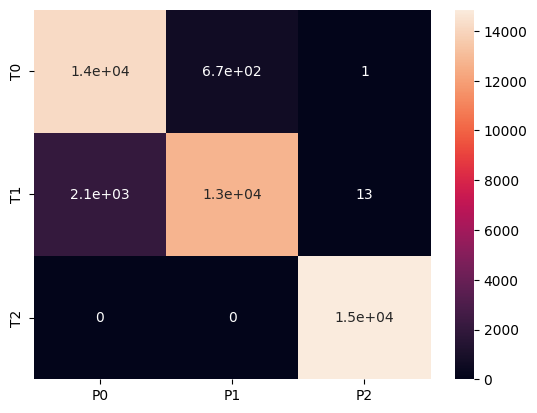

In [79]:
cm = confusion_matrix(y_test, y_pred)
# each row contains all predictions for true label
df_cm = pd.DataFrame(cm, index=[f"T{i}" for i in range(3)],
                     columns=[f"P{j}" for j in range(3)])
sns.heatmap(df_cm, annot=True)

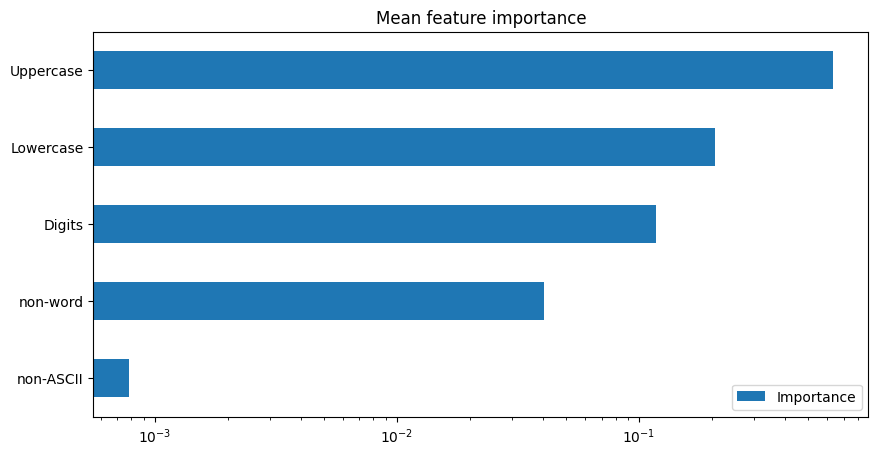

In [91]:
# Let's figure out distinctive features
label_to_desc = {'fd':'Digits',
                 'fu':'Uppercase',
                 'fl':'Lowercase',
                 'fx':'non-word',
                 'fr': 'non-ASCII',
                 }

# create a dataframe with their (mean) importance
f_importance = pd.DataFrame(data=cl.feature_importances_.flatten(),
                            index=[label_to_desc[l] for l in features.columns],
                            columns=["Importance"],
                            )
# sort by importance and plot
ax = f_importance.sort_values("Importance").plot(kind="barh",
                                            title="Mean feature importance",
                                            figsize=(10, 5),
                            )
ax.set_xscale('log')

In [105]:
def check_ur_pwd(p_string, xgb_model):
  """predicts strength of a single password"""
  assert isinstance(p_string, str), 'wrong input'
  p_len = len(p_string)
  # find all matches by patterns, then get frequencies and format for xgb input
  patt = ("\d","[A-Z]", "[a-z]", "[\W_]")
  f = [len(tuple(re.finditer(pattern=p, string=p_string)))/p_len for p in patt]
  f.append((p_len - len(f))/p_len)
  df_single = pd.DataFrame([f], columns=features.columns)
  return xgb_model.predict(df_single).item()

In [111]:
check_ur_pwd(p_string='Arrt34t4eee_', xgb_model=cl)

2

I wish i had more time to implement PyTorch NN models i got used to and beat this baseline